### FTP Connection

In [1]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

In [2]:
# The topic of interest.
topic_dir = "/hourly/precipitation/historical/"
#topic_dir = "/annual/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

In [3]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallelly merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//hourly/precipitation/historical/
data/original/DWD//hourly/precipitation/historical/

data/generated/DWD/
data/generated/DWD//hourly/precipitation/historical/
data/generated/DWD//hourly/precipitation/historical/
data/generated/DWD//hourly/precipitation/historical/


In [5]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

In [6]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [7]:
ret = ftp.cwd(".")

In [8]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to check the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")


### Generate Pandas Dataframe from FTP Directory Listing

In [9]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [10]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [11]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_hourly_precipi...,.pdf,166317,-
1,-1,DESCRIPTION_obsgermany_climate_hourly_precipit...,.pdf,161348,-
2,-1,RR_Stundenwerte_Beschreibung_Stationen.txt,.txt,303009,-
3,3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419296,-
4,20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
5,44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
6,53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
7,71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402875,-
8,73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
9,78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-


In [12]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419296,-
20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402875,-
73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-
87,stundenwerte_RR_00087_20050201_20201231_hist.zip,.zip,403610,-
91,stundenwerte_RR_00091_20040901_20201231_hist.zip,.zip,419182,-


In [13]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

RR_Stundenwerte_Beschreibung_Stationen.txt


In [14]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt
To:   data/original/DWD//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt


In [15]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0, encoding="unicode-escape")
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [16]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2022-03-28,432,48.9219,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg
29,2006-01-10,2022-03-28,260,49.7175,10.9101,Adelsdorf (Kläranlage),Bayern
44,2007-04-01,2022-03-28,44,52.9336,8.2370,Großenkneten,Niedersachsen
46,2006-01-03,2022-03-28,325,48.9450,12.4639,Aholfing,Bayern


In [17]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,   216,   326,   389,   390,   554,   555,   599,   603,
              613,
            ...
            14179, 14180, 14181, 14182, 14183, 14184, 14185, 14186, 14187,
            15000],
           dtype='int64', name='station_id', length=158)

In [18]:
# Create variable with TRUE if state is Nordrhein-Westfalen

# isNRW = df_stations['state'] == "Nordrhein-Westfalen"
isNRW = df_stations['state'].str.contains("Nordrhein")

# Create variable with TRUE if date_to is latest date (indicates operation up to now) and date_from is 2018 and before.
#isOperational = (df_stations['date_to'] >= '2018') &  (df_stations['date_from'] <= '2018')

# select a conditions
dfNRW = df_stations[isNRW]

#print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
216,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
326,2004-07-01,2013-07-08,120,51.7204,8.0577,Beckum-Unterberg,Nordrhein-Westfalen
389,2009-11-01,2022-03-28,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
390,2004-07-01,2022-03-28,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
...,...,...,...,...,...,...,...
14184,2016-06-01,2022-03-28,126,51.2242,7.1070,Wuppertal-Buchenhofen/Wupper,Nordrhein-Westfalen
14185,2017-08-01,2022-03-28,304,51.6050,8.8175,Lichtenau-Ebbinghausen (HRB),Nordrhein-Westfalen
14186,2017-08-01,2022-03-28,291,51.5319,8.7289,Gollentaler Grund (HRB),Nordrhein-Westfalen


In [19]:
print(df_zips)

                                                        name   ext    size  \
station_id                                                                   
3           stundenwerte_RR_00003_19950901_20110401_hist.zip  .zip  419296   
20          stundenwerte_RR_00020_20040814_20201231_hist.zip  .zip  432124   
44          stundenwerte_RR_00044_20070401_20201231_hist.zip  .zip  354983   
53          stundenwerte_RR_00053_20051001_20201231_hist.zip  .zip  385830   
71          stundenwerte_RR_00071_20041022_20200101_hist.zip  .zip  402875   
...                                                      ...   ...     ...   
15555       stundenwerte_RR_15555_20160501_20201231_hist.zip  .zip  120197   
15810       stundenwerte_RR_15810_20180601_20201231_hist.zip  .zip   69532   
19140       stundenwerte_RR_19140_20201101_20201231_hist.zip  .zip    9708   
19171       stundenwerte_RR_19171_20200901_20201231_hist.zip  .zip   12514   
19172       stundenwerte_RR_19172_20200901_20201231_hist.zip  .z

### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations which are TS data provided for (zip files) do not match perfectly.  

In [20]:
list(dfNRW.index)
dfNRW.count

<bound method DataFrame.count of             date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
3          1995-09-01 2011-04-01       202   50.7827     6.0941   
216        2004-10-01 2022-03-28       298   51.1143     7.8807   
326        2004-07-01 2013-07-08       120   51.7204     8.0577   
389        2009-11-01 2022-03-28       436   51.0148     8.4318   
390        2004-07-01 2022-03-28       610   50.9837     8.3683   
...               ...        ...       ...       ...        ...   
14184      2016-06-01 2022-03-28       126   51.2242     7.1070   
14185      2017-08-01 2022-03-28       304   51.6050     8.8175   
14186      2017-08-01 2022-03-28       291   51.5319     8.7289   
14187      2017-08-01 2021-01-07       226   51.5831     8.8478   
15000      2011-04-01 2022-03-28       231   50.7983     6.0244   

                                    name                state  
station_id                     

In [21]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

stundenwerte_RR_00003_19950901_20110401_hist.zip
stundenwerte_RR_00216_20041001_20201231_hist.zip
stundenwerte_RR_00326_20040701_20130708_hist.zip
stundenwerte_RR_00389_20091101_20201231_hist.zip
stundenwerte_RR_00390_20040701_20201231_hist.zip
stundenwerte_RR_00554_19950901_20201231_hist.zip
stundenwerte_RR_00555_20080101_20181101_hist.zip
stundenwerte_RR_00599_19950901_19990302_hist.zip
stundenwerte_RR_00603_19990303_20201231_hist.zip
stundenwerte_RR_00613_20041101_20201231_hist.zip
stundenwerte_RR_00617_20040601_20201231_hist.zip
stundenwerte_RR_00644_20050101_20201231_hist.zip
stundenwerte_RR_00796_20041101_20201231_hist.zip
stundenwerte_RR_00871_20050801_20201231_hist.zip
stundenwerte_RR_00902_20061001_20201231_hist.zip
stundenwerte_RR_00934_20041001_20201231_hist.zip
stundenwerte_RR_00989_20050201_20201231_hist.zip
stundenwerte_RR_01024_20060801_20201231_hist.zip
stundenwerte_RR_01046_20041001_20201231_hist.zip
stundenwerte_RR_01078_19950901_20201231_hist.zip
stundenwerte_RR_0124

### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [22]:
from datetime import datetime

def prec_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=True).str.replace('(', '', regex=True).str.replace(')', '', regex=True)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [23]:
from datetime import datetime

def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN"], date_parser = dateparse, na_values = [-999.0, -999])

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_',regex=True).str.replace('(', '',regex=True).str.replace(')', '',regex=True)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [24]:
from zipfile import ZipFile

In [25]:
# PRECIPITATION
def prec_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [26]:
# TEMPERATURE
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [27]:
df_merged_ts = prec_ts_merge()

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00003_19950901_20110401_hist.zip
Extract product file: produkt_rr_stunde_19950901_20110401_00003.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00216.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00326_20040701_20130708_hist.zip
Extract product file: produkt_rr_stunde_20040701_20130708_00326.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20201231_00389.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_00390.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00554_1995

In [28]:
df_merged_ts.head()

,3,216,326,389,390,554,555,599,603,613,...,7344,7374,7378,13669,13670,13671,13696,13700,13713,15000
time,,,,,,,,,,,,,,,,,,,,,
1995-09-01 00:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 01:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 02:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 03:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 04:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# prec or temp?
filepathname = local_ts_merged_dir + "prec_ts_merged.csv"
print("df_merged_ts is saved to: %s" % (filepathname))
df_merged_ts.to_csv(filepathname,sep=";")

df_merged_ts is saved to: data/generated/DWD//hourly/precipitation/historical/prec_ts_merged.csv


In [30]:
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                # TEMPERATURE  dftmp = temp_ts_to_df(myfile)
                # PRECIPIATION
                dftmp = prec_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
                #print(dftmp.head(5))
                #df = df.append(dftmp)
                df = pd.concat([df,dftmp])

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)
    return(df)

In [31]:
df_appended_ts = ts_append()

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00003_19950901_20110401_hist.zip
Extract product file: produkt_rr_stunde_19950901_20110401_00003.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00216.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00326_20040701_20130708_hist.zip
Extract product file: produkt_rr_stunde_20040701_20130708_00326.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20201231_00389.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_00390.txt

Zip archive: data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00554_1995

In [32]:
df_appended_ts.shape

(12636783, 13)

In [33]:
df_appended_ts.head()

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
1995-09-01 00:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1995-09-01 01:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1995-09-01 02:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1995-09-01 03:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1995-09-01 04:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen


In [54]:
df_appended_ts_roi_idx=df_appended_ts[(df_appended_ts['stations_id']==216) |
               (df_appended_ts['stations_id']==389) |
               (df_appended_ts['stations_id']==390) |
               (df_appended_ts['stations_id']==613) |
               (df_appended_ts['stations_id']==644) |
               (df_appended_ts['stations_id']==796) |
               (df_appended_ts['stations_id']==934) |
               (df_appended_ts['stations_id']==1300) |
               (df_appended_ts['stations_id']==2483) |
               (df_appended_ts['stations_id']==2947) |
               (df_appended_ts['stations_id']==3028) |
               (df_appended_ts['stations_id']==3031) |
               (df_appended_ts['stations_id']==3098) |
               (df_appended_ts['stations_id']==3215) |
               (df_appended_ts['stations_id']==3499) | 
               (df_appended_ts['stations_id']==4127) |
               (df_appended_ts['stations_id']==4313) |
               (df_appended_ts['stations_id']==4368) |
               (df_appended_ts['stations_id']==4400) |
               (df_appended_ts['stations_id']==4488) | 
               (df_appended_ts['stations_id']==4692) |
               (df_appended_ts['stations_id']==5347) | 
               (df_appended_ts['stations_id']==5360) |
               (df_appended_ts['stations_id']==5468) |
               (df_appended_ts['stations_id']==5480) | 
               (df_appended_ts['stations_id']==5619) |
               (df_appended_ts['stations_id']==5699) |
               (df_appended_ts['stations_id']==6264) |
               (df_appended_ts['stations_id']==6276) |
               (df_appended_ts['stations_id']==6313) |
               (df_appended_ts['stations_id']==7330) |
               (df_appended_ts['stations_id']==13700) |
               (df_appended_ts['stations_id']==13713) |
               (df_appended_ts['stations_id']==14143) |
               (df_appended_ts['stations_id']==14145) | 
               (df_appended_ts['stations_id']==14170) | 
               (df_appended_ts['stations_id']==14171) |
               (df_appended_ts['stations_id']==14172) |
               (df_appended_ts['stations_id']==14173) |
               (df_appended_ts['stations_id']==14182) |
               (df_appended_ts['stations_id']==14183) |
               (df_appended_ts['stations_id']==14185) |
               (df_appended_ts['stations_id']==14186) |                                        
               (df_appended_ts['stations_id']==14187)]   
df_appended_ts_roi_idx

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2004-10-01 00:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 01:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 02:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 03:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 04:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,13713,3,0.0,1.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 21:00:00,13713,3,0.1,1.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


In [55]:
# the date of interest is selected from 2018-04-16 to 2018-08-16
idx=(df_appended_ts_roi_idx.index >= '2018-04-16 00:00:00') & (df_appended_ts_roi_idx.index <'2018-08-16 00:00:00')

In [56]:
df_appended_ts_coi=df_appended_ts_roi_idx[idx]
df_appended_ts_coi.tail()

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2018-08-15 19:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 21:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 22:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 23:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


In [57]:
df_appended_ts_coi.head(100)
#df_appended_ts_countiesofinterest.reset_index(level=0, inplace=True)
df_appended_ts_coi.to_csv(r"data/generated/13_counties_stations_April_to_August_data.csv")

In [58]:
df_appended_ts_coi.reset_index(level=0, inplace=True)

In [59]:
#df_appended_ts_coi.reset_index(level=0, inplace=True)
df_appended_ts_coi

,mess_datum,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
0,2018-04-16 00:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
1,2018-04-16 01:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2,2018-04-16 02:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
3,2018-04-16 03:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
4,2018-04-16 04:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96195,2018-08-15 19:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
96196,2018-08-15 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
96197,2018-08-15 21:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
96198,2018-08-15 22:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


In [60]:
#Importing the required packages
import os
import ftplib
import pandas as pd
import time
import datetime
import codecs
import numpy as np
import seaborn as sns
from datetime import datetime
from zipfile import ZipFile
from matplotlib import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors
from adjustText import adjust_text
from sklearn.linear_model import LinearRegression


In [61]:
data_frame = pd.read_csv('data/generated/13_counties_stations_April_to_August_data.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_frame

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2018-04-16 00:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2018-04-16 01:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2018-04-16 02:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2018-04-16 03:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2018-04-16 04:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-28,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-15 19:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 21:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-28,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


In [62]:
df_appended_ts_coi.reset_index(level=0, inplace=True)
df = data_frame.groupby(['stations_id', 'altitude',
                        'latitude', 'longitude', 'name', 'state'])['r1'].sum()


In [68]:
df = pd.DataFrame(df)
df.reset_index(level=0, inplace=True)
df

,state,name,longitude,latitude,altitude,stations_id,r1
0,Nordrhein-Westfalen,Attendorn-Neulisternohl,7.8807,51.1143,298,216,273.7
1,Nordrhein-Westfalen,"Berleburg, Bad-Arfeld",8.4318,51.0148,436,389,175.6
2,Nordrhein-Westfalen,"Berleburg, Bad-Stünzel",8.3683,50.9837,610,390,179.2
3,Nordrhein-Westfalen,Borgentreich,9.2324,51.5677,206,613,130.1
4,Nordrhein-Westfalen,Brakel,9.1738,51.7049,150,644,115.0
5,Nordrhein-Westfalen,Burbach-Würgendorf,8.1257,50.7556,412,796,168.0
6,Nordrhein-Westfalen,Delbrück,8.5658,51.7835,88,934,116.8
7,Nordrhein-Westfalen,Eslohe,8.1565,51.2540,351,1300,201.8
8,Nordrhein-Westfalen,Kahler Asten,8.4891,51.1803,839,2483,222.2
9,Nordrhein-Westfalen,Lennestadt-Theten,8.0348,51.1333,286,2947,291.1


In [69]:
#df.reset_index(level=0, inplace=True)
columns_titles = ["stations_id","r1","altitude","latitude","longitude","name","state" ]
df=df.reindex(columns=columns_titles)
df

,stations_id,r1,altitude,latitude,longitude,name,state
0,216,273.7,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
1,389,175.6,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
2,390,179.2,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
3,613,130.1,206,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen
4,644,115.0,150,51.7049,9.1738,Brakel,Nordrhein-Westfalen
5,796,168.0,412,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen
6,934,116.8,88,51.7835,8.5658,Delbrück,Nordrhein-Westfalen
7,1300,201.8,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
8,2483,222.2,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
9,2947,291.1,286,51.1333,8.0348,Lennestadt-Theten,Nordrhein-Westfalen


In [70]:
#df.reset_index(level=0, inplace=True)

In [71]:
df.rename(columns={'r1': 'cum_preci'}, inplace=True)
df

,stations_id,cum_preci,altitude,latitude,longitude,name,state
0,216,273.7,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
1,389,175.6,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
2,390,179.2,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
3,613,130.1,206,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen
4,644,115.0,150,51.7049,9.1738,Brakel,Nordrhein-Westfalen
5,796,168.0,412,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen
6,934,116.8,88,51.7835,8.5658,Delbrück,Nordrhein-Westfalen
7,1300,201.8,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
8,2483,222.2,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
9,2947,291.1,286,51.1333,8.0348,Lennestadt-Theten,Nordrhein-Westfalen


In [72]:
df.to_csv(r'data/generated/visualizaion_data_5.csv', index = False)

# Graphical Analysis
## Analyse cumulative precipitation vs altitude (DTM)

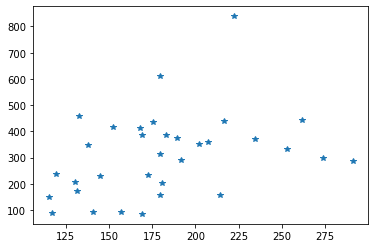

In [76]:
#df[['prec_value', 'altitude']].plot()
x= df['cum_preci']
y= df['altitude']
plt.plot(x, y, '*')

In [77]:
%pip install adjustText

Note: you may need to restart the kernel to use updated packages.


In [79]:
#import scipy
#slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(val, altitude)
#print(slope, intercept, r_value, p_value, std_err)
#Regression_val_square = r_value * r_value
#print(Regression_val_square)

In [80]:
from numpy.random import seed
from scipy.stats import linregress
from adjustText import adjust_text

# prepare data for the scatter plot.
cum_precipitation = df['cum_preci']
altitude = df['altitude']

slope, intercept, r, p, stderr = linregress(cum_precipitation, altitude)
print(slope, intercept, r, p, stderr)
Regression_square = r * r
print(Regression_square)

1.2311568276681857 87.16784671405856 0.3525850360142105 0.044167182036121494 0.5868705415004956
0.12431620762114211


C:\Users\Besitzer\AppData\Local\Temp\ipykernel_16624\840237734.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


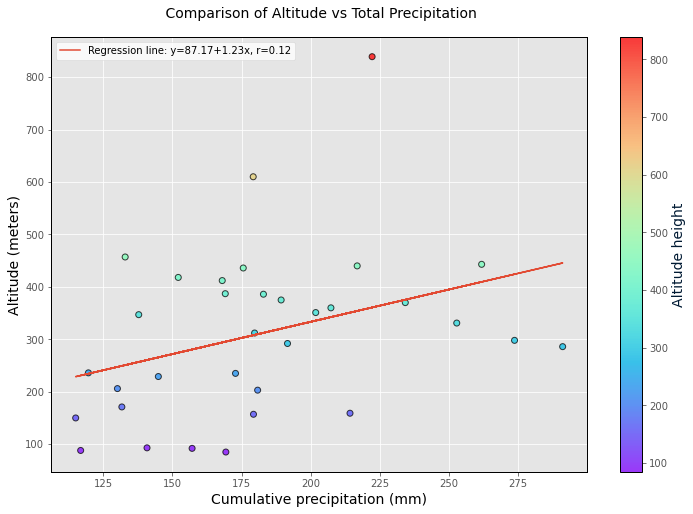

In [83]:
# seed random number generator
seed(1)

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={Regression_square:.2f}'
line

plt.style.use('ggplot')

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

fig, ax = plt.subplots(figsize=(12, 8))

#ax.plot(cum_precipitation, altitude, linewidth=0, marker='*', markersize=7, label='Weather stations')
ax.plot(cum_precipitation, intercept + slope * cum_precipitation, label=line)
ax.set_xlabel('Cumulative precipitation (mm)', fontsize=14, color='black')
ax.set_ylabel('Altitude (meters)', fontsize=14, color='black')
plt.scatter(val, altitude, c = altitude, cmap = 'rainbow',  edgecolor = 'black', linewidth = 1, alpha = 0.75)
cbar = plt.colorbar()
cbar.set_label("Altitude height",fontdict={'fontname' : 'Sans-Serif', 'fontsize': 14}, color= '#001a33')
ax.set_title(" Comparison of Altitude vs Total Precipitation", fontsize=14, y=1.03, color='black')
ax.legend(facecolor='white')
plt.grid(True)
plt.savefig("E:/rhein-waal/GeoInformatics_Final_Project/group_12/Excercise/Final Image/Excercise5/altitude_vs_cum_preci_coi.png", dpi=600)
plt.show()

In [84]:
dtm_data_frame = pd.read_csv('data/generated/altitude_data.csv', index_col=0, parse_dates=True, infer_datetime_format=True)

In [85]:
dtm_data_frame.reset_index(level=0, inplace=True)
dtm_data_frame

,stations_id,prec_value,altitude,latitude,longitude,name,state,SAMPLE_1
0,216,273.7,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen,298.100006
1,389,175.6,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen,433.500000
2,390,179.2,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen,612.200012
3,613,130.1,206,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen,205.000000
4,644,115.0,150,51.7049,9.1738,Brakel,Nordrhein-Westfalen,150.199997
5,796,168.0,412,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen,413.399994
6,934,116.8,88,51.7835,8.5658,Delbrück,Nordrhein-Westfalen,87.700005
7,1300,201.8,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen,354.800018
8,2483,222.2,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen,838.500000
9,2947,291.1,286,51.1333,8.0348,Lennestadt-Theten,Nordrhein-Westfalen,287.000000


In [86]:
dtm_data_frame.rename(columns={'SAMPLE_1': 'dtm_altitude'}, inplace=True)

In [87]:
dtm_data_frame

,stations_id,prec_value,altitude,latitude,longitude,name,state,dtm_altitude
0,216,273.7,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen,298.100006
1,389,175.6,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen,433.500000
2,390,179.2,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen,612.200012
3,613,130.1,206,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen,205.000000
4,644,115.0,150,51.7049,9.1738,Brakel,Nordrhein-Westfalen,150.199997
5,796,168.0,412,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen,413.399994
6,934,116.8,88,51.7835,8.5658,Delbrück,Nordrhein-Westfalen,87.700005
7,1300,201.8,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen,354.800018
8,2483,222.2,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen,838.500000
9,2947,291.1,286,51.1333,8.0348,Lennestadt-Theten,Nordrhein-Westfalen,287.000000


In [88]:
altitude = dtm_data_frame['altitude']
dtm_altitude= dtm_data_frame['dtm_altitude']
labels = dtm_data_frame['stations_id']

In [89]:
#storing all 13 counties stations in array
st = [216, 389, 390, 613, 644, 796, 934, 1300, 2483, 2947, 3028, 3031, 3098, 3215, 3499, 4127, 4313, 4368, 4400, 4488, 4692, 5347, 5360, 5468, 5480, 5619, 5699, 6264, 6276, 6313, 7330, 13700, 13713]

In [90]:
#Using pandas resample method to calculate the sum of precipitation for all 13 countie from time period 2018-04-16 to 2018-08-16
df_new = data_frame.loc[data_frame['stations_id'].isin(st)].reset_index().pivot(index='mess_datum', columns='stations_id', values=['r1']).resample('Y').sum()

In [91]:
#Drop unwanted mess_datum column 
df_st = df_new.reset_index().drop('mess_datum', axis=1)

C:\Users\Besitzer\AppData\Local\Temp\ipykernel_16624\4158475362.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_st = df_new.reset_index().drop('mess_datum', axis=1)


In [92]:
#reset index and column
df_r1 = df_st.transpose()

#reset index
clean_df = df_r1.reset_index()

#renaming column
rain_df = clean_df.rename(columns={0: "rainfall"})

rain_df.head()

,level_0,stations_id,rainfall
0,r1,216,273.7
1,r1,389,175.6
2,r1,390,179.2
3,r1,613,130.1
4,r1,644,115.0


## Filtering station altitude from df_appended_ts_April_to_Aug dataframe

In [93]:
store_altitude = data_frame

In [94]:
df_altitude = store_altitude.loc[store_altitude['stations_id'].isin(st)].groupby(['stations_id', 'altitude']).first().reset_index().drop('r1', axis=1)
df_altitude

,stations_id,altitude,qn_8,rs_ind,wrtr,eor,date_from,date_to,latitude,longitude,name,state
0,216,298,3,0.0,NaN,eor,2004-10-01,2022-03-28,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
1,389,436,3,0.0,NaN,eor,2009-11-01,2022-03-28,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
2,390,610,3,0.0,NaN,eor,2004-07-01,2022-03-28,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
3,613,206,3,0.0,NaN,eor,2004-11-01,2022-03-28,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen
4,644,150,3,0.0,NaN,eor,2005-01-01,2022-03-28,51.7049,9.1738,Brakel,Nordrhein-Westfalen
5,796,412,3,0.0,NaN,eor,2004-11-01,2022-03-28,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen
6,934,88,3,0.0,NaN,eor,2004-10-01,2022-03-28,51.7835,8.5658,Delbrück,Nordrhein-Westfalen
7,1300,351,3,0.0,NaN,eor,2004-06-01,2022-03-28,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
8,2483,839,3,0.0,0.0,eor,1995-10-12,2022-03-28,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
9,2947,286,3,0.0,NaN,eor,2006-10-01,2022-03-28,51.1333,8.0348,Lennestadt-Theten,Nordrhein-Westfalen


# Merging Rainfall and Altitude dataframes

In [95]:
result = pd.merge(rain_df, df_altitude)

In [96]:
#setting station id as index for graphical analysis
idx_st = result.set_index('stations_id')

C:\Users\Besitzer\anaconda3\envs\geoinfo\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<Figure size 2400x1600 with 0 Axes>

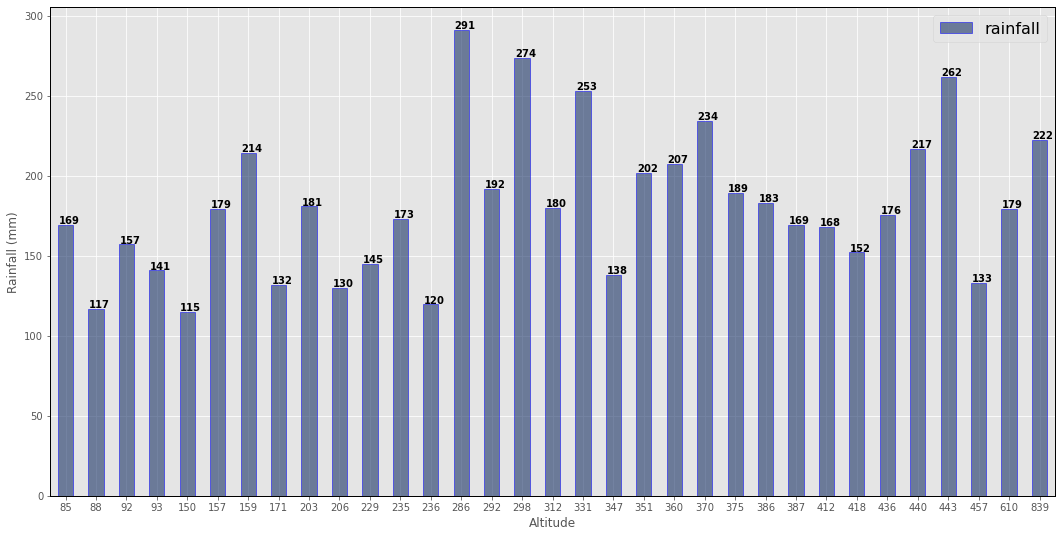

In [97]:
import matplotlib.pyplot as plt
import seaborn as sb
sort_df = idx_st.sort_values(by=['altitude'])
fig = plt.figure(dpi=400)
sort_df.plot.bar(x='altitude',y='rainfall', figsize=(18,9), color=(0.1, 0.2, 0.4, 0.6),  edgecolor='blue')
for i, number in enumerate(sort_df['rainfall']):
    plt.text(x=i-.23, y=number + 0.9, s=round(number), weight='bold')
plt.xticks(rotation=0)
plt.legend(['rainfall'], loc="upper right", fontsize=16)
plt.xlabel("Altitude", fontsize=12)
plt.ylabel("Rainfall (mm)", fontsize=12)
plt.savefig('E:/rhein-waal/GeoInformatics_Final_Project/group_12/Excercise/Final Image/Excercise5/altibar.png', dpi=500)
plt.show()

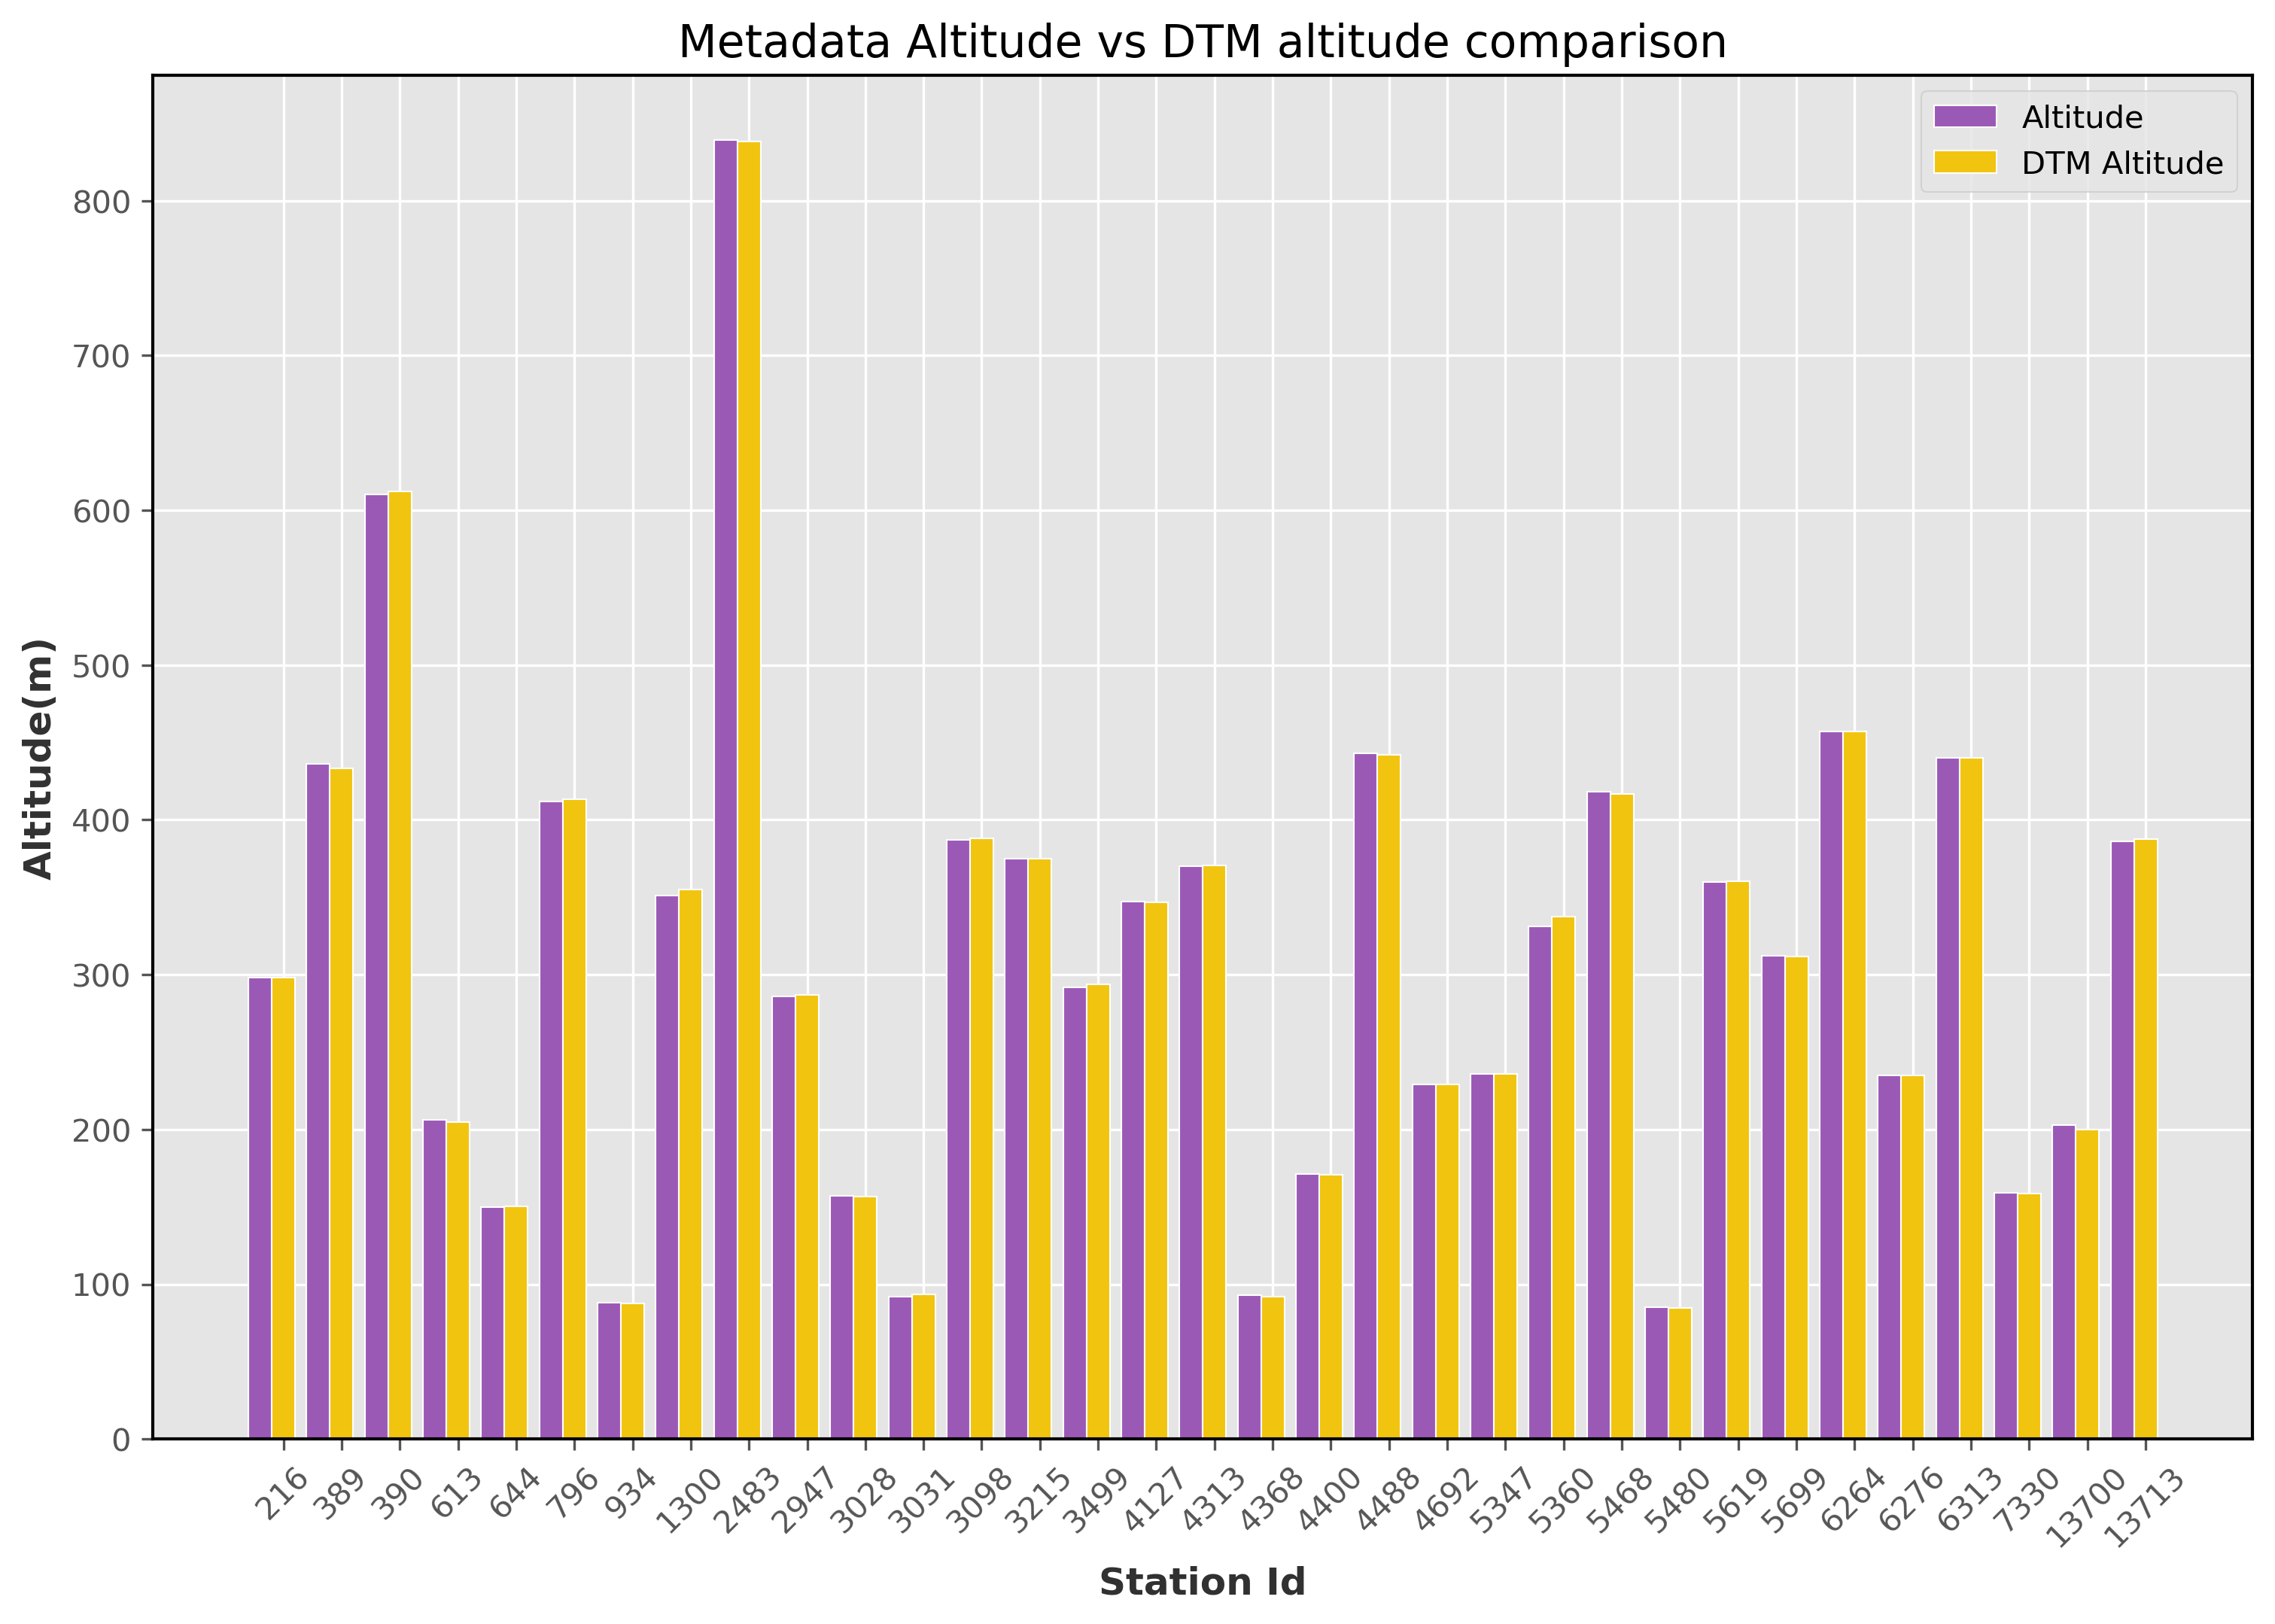

In [98]:
fig = plt.figure(dpi = 300, figsize = (12, 8), clear = True)
# set width of bars
bar_width = 0.40
r1 = np.arange(len(altitude))
r2 = [x + bar_width for x in r1]

# Make the plot
plt.bar(r1, altitude, color='#9B59B6', width=bar_width, edgecolor='white', label='Altitude')
plt.bar(r2, dtm_altitude, color='#F1C40F', width=bar_width, edgecolor='white', label='DTM Altitude')
 
# Add xticks on the middle of the group bars
plt.xlabel('Station Id', fontweight='bold', color='#313131')
plt.ylabel('Altitude(m)', fontweight='bold',color='#313131')
plt.xticks([r + bar_width for r in range(len(altitude))], labels, rotation= 45)
plt.title("Metadata Altitude vs DTM altitude comparison",)
 
# Create legend & Show graphic
plt.legend()
fig.savefig('E:/rhein-waal/GeoInformatics_Final_Project/group_12/Excercise/Final Image/Excercise5/altitude_vs_dtm_altitude.jpeg')
plt.show()